# Description

Generates the figure for top cell types for a specified LV (in Settings section below).

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

In [3]:
LV_NAME = "LV260"

In [4]:
LV_AXIS_THRESHOLD = 3.0
N_TOP_SAMPLES = 300
N_TOP_ATTRS = 25

In [5]:
OUTPUT_FIGURES_DIR = Path(
    conf.MANUSCRIPT["FIGURES_DIR"], "lvs_analysis", f"{LV_NAME.lower()}"
).resolve()
display(OUTPUT_FIGURES_DIR)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv260')

In [6]:
OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
display(OUTPUT_CELL_TYPE_FILEPATH)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv260/lv260-cell_types.svg')

# Load MultiPLIER summary

In [7]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [8]:
multiplier_model_summary.shape

(2157, 5)

In [9]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [10]:
INPUT_SUBSET = "z_score_std"

In [11]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [12]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases_data/base_orig/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [13]:
data = pd.read_pickle(input_filepath)

In [14]:
data.shape

(3752, 987)

In [15]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## LV data

In [16]:
lv_obj = LVAnalysis(LV_NAME, data)

In [17]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        | (multiplier_model_summary["AUC"] >= 0.75)
    )
]

[2021-08-02 22:26:29,270 - numexpr.utils] INFO: NumExpr defaulting to 8 threads.


,pathway,LV index,AUC,p-value,FDR


In [18]:
lv_data = lv_obj.get_experiments_data()

SRP055569, SRP057196, SRP007508, SRP055153, SRP042161, SRP066834, SRP059732, SRP033135, SRP059775, SRP058773, SRP064464, SRP022892, SRP060416, SRP050440, SRP014009, SRP009266, SRP050992, SRP018853, SRP029334, SRP012461, SRP043593, SRP011054, SRP050499, SRP059035, SRP065202, SRP057205, SRP015668, SRP059379, SRP051765, SRP055810, SRP013725, SRP058626, SRP030617, SRP010279, SRP058237, SRP042620, SRP029656, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (35 != 37)
  warnings.warn(


In [19]:
lv_data.shape

(6284, 64)

In [20]:
lv_data.head()

cell type tissue  age c1 chip id  \
project   run                                                                   
SRP055569 SRR1821717  MCF10a human breast cancer cells    NaN  NaN        NaN   
          SRR1821716  MCF10a human breast cancer cells    NaN  NaN        NaN   
          SRR1821715  MCF10a human breast cancer cells    NaN  NaN        NaN   
          SRR1821714  MCF10a human breast cancer cells    NaN  NaN        NaN   
          SRR1821713  MCF10a human breast cancer cells    NaN  NaN        NaN   

                     experiment_sample_name subcellular cell line patient id  \
project   run                                                                  
SRP055569 SRR1821717                    NaN         NaN       NaN        NaN   
          SRR1821716                    NaN         NaN       NaN        NaN   
          SRR1821715                    NaN         NaN       NaN        NaN   
          SRR1821714                    NaN         NaN       NaN        NaN   
          SRR1821713                    NaN         NaN       NaN        NaN   

                     subtype Stage  ... lineage embryo number tumor stage  \
project   run                       ...                                     
SRP055569 SRR1821717     NaN   NaN  ...     NaN           NaN         NaN   
          SRR1821716     NaN   NaN  ...     NaN           NaN         NaN   
          SRR1821715     NaN   NaN  ...     NaN           NaN         NaN   
          SRR1821714     NaN   NaN  ...     NaN           NaN         NaN   
          SRR1821713     NaN   NaN  ...     NaN           NaN         NaN   

                     cdna synthesis method library construction method  \
project   run                                                            
SRP055569 SRR1821717                   NaN                         NaN   
          SRR1821716                   NaN                         NaN   
          SRR1821715                   NaN                         NaN   
          SRR1821714                   NaN                         NaN   
          SRR1821713                   NaN                         NaN   

                     antibody catalog # antibody lot # antibody manufacturer  \
project   run                                                                  
SRP055569 SRR1821717                NaN            NaN                   NaN   
          SRR1821716                NaN            NaN                   NaN   
          SRR1821715                NaN            NaN                   NaN   
          SRR1821714                NaN            NaN                   NaN   
          SRR1821713                NaN            NaN                   NaN   

                     sample type     LV260  
project   run                               
SRP055569 SRR1821717         NaN -0.068300  
          SRR1821716         NaN -0.054044  
          SRR1821715         NaN -0.037828  
          SRR1821714         NaN  0.072631  
          SRR1821713         NaN  0.010307  

[5 rows x 64 columns]

# LV cell types analysis

## Get top attributes

In [21]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

cell type                         0.029856
subcellular                       0.016286
cell storage                      0.005287
tumor subpopulation               0.005287
tumor state                       0.005287
rna associated                    0.004097
culture medium                    0.003888
antibody                          0.003217
age                               0.002240
c1 chip id                        0.002240
experiment_sample_name            0.002240
reprogramming time point (day)    0.002032
well number                       0.002032
iPSc                              0.002029
reprogramming vector              0.002029
time                              0.002029
patient id                        0.001754
sample molecule                   0.001653
tonsil donor                      0.001570
facs gating                       0.001570
dtype: float64

In [22]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.+type$)|(?:tissue$)|(?:tissue.+type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

cell type    0.029856
tissue       0.001551
dtype: float64

In [23]:
_tmp = lv_data.loc[
    :,
    [
        "cell type",
        "tissue",
        LV_NAME,
    ],
]

In [24]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

In [25]:
_tmp_seq[0]

cell type  \
project   run                                                             
SRP055569 SRR1821615  mixture of U87 human glioma cells and MCF10a h...   
          SRR1821352                             U87 human glioma cells   
          SRR1821494  mixture of U87 human glioma cells and MCF10a h...   
          SRR2019012                             U87 human glioma cells   
          SRR1821530  mixture of U87 human glioma cells and MCF10a h...   
          SRR1821368                             U87 human glioma cells   
          SRR2018998                             U87 human glioma cells   
SRP057196 SRR1974663                                            neurons   
SRP055569 SRR1821404                             U87 human glioma cells   
          SRR1821464  mixture of U87 human glioma cells and MCF10a h...   
          SRR1821668                   MCF10a human breast cancer cells   
          SRR1821557  mixture of U87 human glioma cells and MCF10a h...   
SRP007508 SRR324841                                          143B cells   
SRP055153 SRR1810660                                            no cell   
SRP042161 SRR1294536                                       Glioblastoma   
SRP057196 SRR1974778                                            neurons   
SRP066834 SRR2967311                                                NaN   
SRP055569 SRR1821365                             U87 human glioma cells   
SRP059732 SRR2072589                                                NaN   
SRP055569 SRR1821573  mixture of U87 human glioma cells and MCF10a h...   
          SRR1821667                   MCF10a human breast cancer cells   
          SRR2019028                             U87 human glioma cells   
          SRR1821544  mixture of U87 human glioma cells and MCF10a h...   
          SRR1821587  mixture of U87 human glioma cells and MCF10a h...   
SRP033135 SRR1033244             Human Skeletal Muscle Myoblasts (HSMM)   

                                                   tissue      LV260  
project   run                                                         
SRP055569 SRR1821615                                  NaN  10.814957  
          SRR1821352                                  NaN   0.638319  
          SRR1821494                                  NaN   0.458601  
          SRR2019012                                  NaN   0.441287  
          SRR1821530                                  NaN   0.395341  
          SRR1821368                                  NaN   0.387595  
          SRR2018998                                  NaN   0.357789  
SRP057196 SRR1974663                               cortex   0.342670  
SRP055569 SRR1821404                                  NaN   0.327369  
          SRR1821464                                  NaN   0.311411  
          SRR1821668                                  NaN   0.299611  
          SRR1821557                                  NaN   0.283923  
SRP007508 SRR324841                                   NaN   0.281237  
SRP055153 SRR1810660                                  NaN   0.274736  
SRP042161 SRR1294536                                  NaN   0.269407  
SRP057196 SRR1974778                               cortex   0.267910  
SRP066834 SRR2967311  Dissociated whole cerebral organoid   0.263015  
SRP055569 SRR1821365                                  NaN   0.260679  
SRP059732 SRR2072589                                  NaN   0.257881  
SRP055569 SRR1821573                                  NaN   0.255989  
          SRR1821667                                  NaN   0.254882  
          SRR2019028                                  NaN   0.253525  
          SRR1821544                                  NaN   0.242371  
          SRR1821587                                  NaN   0.235679  
SRP033135 SRR1033244                                  NaN   0.234171

In [26]:
# what is there in these projects?
lv_data.loc[["SRP058773"]].dropna(how="all", axis=1).sort_values(
    LV_NAME, ascending=False
).sort_values(LV_NAME, ascending=False).head(10)

well number reprogramming time point (day)     LV260
project   run                                                            
SRP058773 SRR2042627          89                             10  0.200857
          SRR2042608          91                             10  0.139070
          SRR2042659          50                             10  0.098458
          SRR2042617          40                             10  0.083706
          SRR2042616          61                             10  0.064015
          SRR2042643          65                             10  0.040964
          SRR2042633          84                             10  0.040834
          SRR2042630          21                             10  0.038156
          SRR2042653           9                             10  0.029074
          SRR2042621          39                             10  0.026702

In [27]:
SELECTED_ATTRIBUTE = "cell type"

In [28]:
# it has to be in the order desired for filling nans in the SELECTED_ATTRIBUTE
SECOND_ATTRIBUTES = ["tissue"]

## Get plot data

In [29]:
plot_data = lv_data.loc[:, [SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES + [LV_NAME]]

In [30]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[[SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES].fillna(
    method="backfill", axis=1
)[SELECTED_ATTRIBUTE]
plot_data[SELECTED_ATTRIBUTE] = _new_column
plot_data = plot_data.drop(columns=SECOND_ATTRIBUTES)
plot_data = plot_data.fillna({SELECTED_ATTRIBUTE: "NOT CATEGORIZED"})
# plot_data = plot_data.dropna(subset=[SELECTED_ATTRIBUTE])

In [31]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [32]:
plot_data.head(20)

cell type  \
project   run                                                             
SRP055569 SRR1821615  mixture of U87 human glioma cells and MCF10a h...   
          SRR1821352                             U87 human glioma cells   
          SRR1821494  mixture of U87 human glioma cells and MCF10a h...   
          SRR2019012                             U87 human glioma cells   
          SRR1821530  mixture of U87 human glioma cells and MCF10a h...   
          SRR1821368                             U87 human glioma cells   
          SRR2018998                             U87 human glioma cells   
SRP057196 SRR1974663                                            neurons   
SRP055569 SRR1821404                             U87 human glioma cells   
          SRR1821464  mixture of U87 human glioma cells and MCF10a h...   
          SRR1821668                   MCF10a human breast cancer cells   
          SRR1821557  mixture of U87 human glioma cells and MCF10a h...   
SRP007508 SRR324841                                          143B cells   
SRP055153 SRR1810660                                            no cell   
SRP042161 SRR1294536                                       Glioblastoma   
SRP057196 SRR1974778                                            neurons   
SRP066834 SRR2967311                Dissociated whole cerebral organoid   
SRP055569 SRR1821365                             U87 human glioma cells   
SRP059732 SRR2072589                                    NOT CATEGORIZED   
SRP055569 SRR1821573  mixture of U87 human glioma cells and MCF10a h...   

                          LV260  
project   run                    
SRP055569 SRR1821615  10.814957  
          SRR1821352   0.638319  
          SRR1821494   0.458601  
          SRR2019012   0.441287  
          SRR1821530   0.395341  
          SRR1821368   0.387595  
          SRR2018998   0.357789  
SRP057196 SRR1974663   0.342670  
SRP055569 SRR1821404   0.327369  
          SRR1821464   0.311411  
          SRR1821668   0.299611  
          SRR1821557   0.283923  
SRP007508 SRR324841    0.281237  
SRP055153 SRR1810660   0.274736  
SRP042161 SRR1294536   0.269407  
SRP057196 SRR1974778   0.267910  
SRP066834 SRR2967311   0.263015  
SRP055569 SRR1821365   0.260679  
SRP059732 SRR2072589   0.257881  
SRP055569 SRR1821573   0.255989

## Customize x-axis values

When cell type values are not very clear, customize their names by looking at their specific studies to know exactly what the authors meant.

In [33]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTE: {
            # SRP057196
            "fetal_quiescent": "Fetal neurons (quiescent)",
            "fetal_replicating": "Fetal neurons (replicating)",
            # SRP055569
            "mixture of U87 human glioma cells and WI-38 human lung fibroblast cells": "Glioma cells + lung fibroblast cells",
            "mixture of U87 human glioma cells and MCF10a human breast cancer cells": "Glioma cells + breast cancer cells",
        }
    }
)

final_plot_data = final_plot_data[plot_data[SELECTED_ATTRIBUTE] != "no cell"]

In [34]:
# # add also tissue information to these projects
_srp_code = "SRP057196"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: x[SELECTED_ATTRIBUTE]
    + f" ({lv_data.loc[(_srp_code, x.name), 'tissue']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

<ipython-input-34-26d4d9c15426>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = final_plot_data.loc[(_srp_code,)].apply(


In [35]:
# take the top samples only
final_plot_data = final_plot_data.sort_values(LV_NAME, ascending=False)[:N_TOP_SAMPLES]

## Threshold LV values

In [36]:
final_plot_data.loc[
    final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

In [37]:
final_plot_data = final_plot_data[
    final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
]

## Set x-axis order

In [38]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTE)
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [39]:
len(attr_order)

25

In [40]:
attr_order[:5]

['Glioma cells + breast cancer cells',
 'U87 human glioma cells',
 'neurons (cortex)',
 'MCF10a human breast cancer cells',
 '143B cells']

## Plot

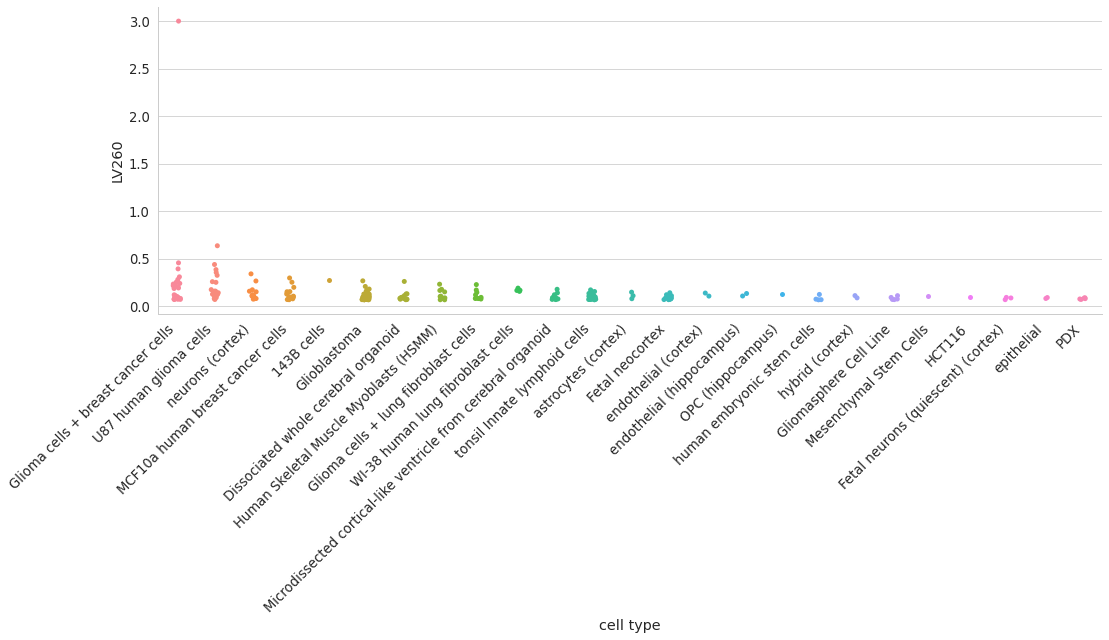

In [41]:
with sns.plotting_context("paper", font_scale=1.5), sns.axes_style("whitegrid"):
    sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTE,
        order=attr_order,
        kind="strip",
        height=5,
        aspect=3,
    )
    plt.xticks(rotation=45, horizontalalignment="right")

    plt.savefig(
        OUTPUT_CELL_TYPE_FILEPATH,
        bbox_inches="tight",
        facecolor="white",
    )

# Debug

In [42]:
# with pd.option_context(
#     "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
# ):
#     _tmp = final_plot_data[final_plot_data[SELECTED_ATTRIBUTE].str.contains("neurons")]
#     display(_tmp.head(20))

In [43]:
# # what is there in these projects?
# lv_data.loc[["SRP050499"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# ).head(60)